# Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name="/content/drive/MyDrive/FMDS333.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import os
import PIL
import cv2
import pickle
import time # for computation time assessment
import matplotlib.pyplot as plt 
%matplotlib inline

## Feature extraction

In [ ]:
DIRECTORY = "/content/FMDS333/dataset"


CATEGORIES = ['without_mask','incorrect_mask', 'with_mask']
IMG_SIZE = 64

#data
X = []
#labels(0,1,2)
y = []

def create_data():
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)
        class_num_label = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                X.append(img_array)
                y.append(class_num_label)
            except Exeption as e:
                pass
            
create_data()

In [ ]:
len(X)

9000

In [ ]:
X[0]

array([[ 52,  39,  39, ..., 247, 248, 249],
       [ 54,  42,  32, ..., 247, 248, 248],
       [ 55,  48,  36, ..., 247, 248, 249],
       ...,
       [253, 254, 254, ..., 251, 250, 250],
       [253, 254, 254, ..., 251, 250, 250],
       [253, 254, 254, ..., 251, 250, 250]], dtype=uint8)

## Convert to Numpy Array

In [ ]:
# Get images as a 4,096 feature set
SAMPLE_SIZE = len(y)
data = np.array(X).flatten().reshape(SAMPLE_SIZE, IMG_SIZE*IMG_SIZE) # pixel-features

# Turn X and y into numpy arrays
X = np.array(X)
y = np.array(y) # target

print("Features, X shape: ", X.shape)
print("Target, y shape: ", y.shape)
print("Data shape: ", data.shape)

Features, X shape:  (9000, 64, 64)
Target, y shape:  (9000,)
Data shape:  (9000, 4096)


In [ ]:
X

array([[[ 52,  39,  39, ..., 247, 248, 249],
        [ 54,  42,  32, ..., 247, 248, 248],
        [ 55,  48,  36, ..., 247, 248, 249],
        ...,
        [253, 254, 254, ..., 251, 250, 250],
        [253, 254, 254, ..., 251, 250, 250],
        [253, 254, 254, ..., 251, 250, 250]],

       [[242, 244, 245, ...,  73,  68,  46],
        [242, 244, 245, ...,  68,  43,  32],
        [242, 244, 244, ...,  44,  47,  37],
        ...,
        [227, 233, 237, ..., 252, 251, 253],
        [227, 233, 237, ..., 251, 252, 253],
        [227, 233, 237, ..., 253, 253, 252]],

       [[ 22,  37,  34, ..., 123, 131, 128],
        [ 20,  31,  44, ..., 125, 131, 128],
        [ 18,  18,  49, ..., 128, 130, 129],
        ...,
        [ 72,  70,  71, ..., 130, 130, 131],
        [ 81,  76,  77, ..., 130, 130, 131],
        [ 88,  83,  86, ..., 130, 130, 131]],

       ...,

       [[218, 218, 218, ..., 172, 146, 124],
        [218, 218, 218, ..., 178, 149, 138],
        [218, 218, 218, ..., 173, 173, 154

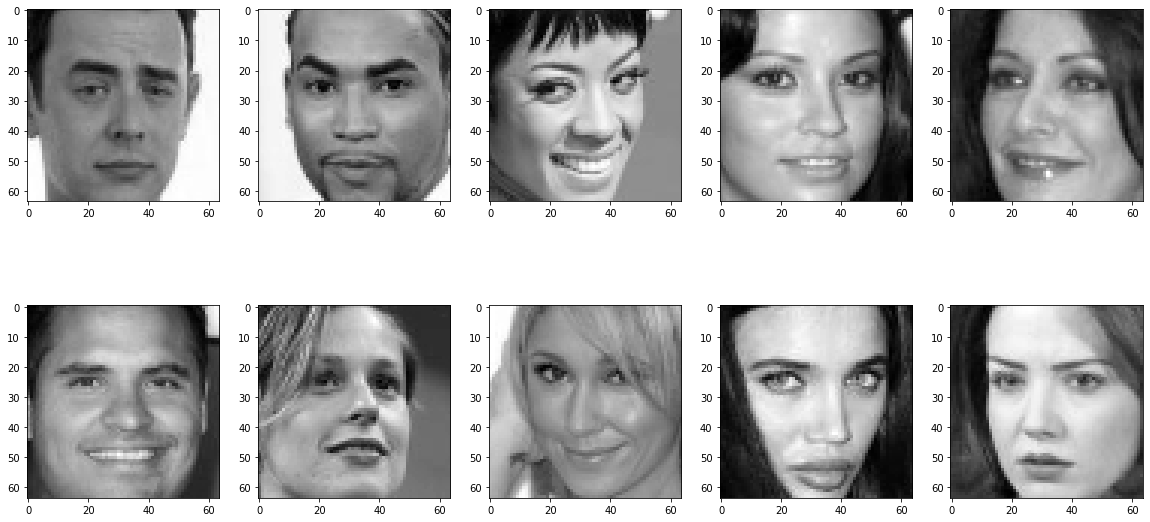

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(10):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i],cmap=plt.cm.gray,interpolation='nearest')

## Save Dataset as Pickles
Since storing image files can be very big, pickling makes it easier to work with the data across our models. It also helps us avoid the feature extraction step again and ensure that we are all working with the same data.

In [ ]:
#Saves us from having to regenerate our data by saving our data
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle", "wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)
pickle_in = open("data.pickle", "rb")
data = pickle.load(pickle_in)

In [ ]:
y

array([0, 0, 0, ..., 2, 2, 2])

##  Total Classification Counts

In [ ]:
print('# of Samples:', len(y))
print('# of Without A Mask:', (y == 0).sum())
print('# of Incorrectly Worn Mask:', (y == 1).sum())
print('# of With A Mask:', (y == 2).sum())

# of Samples: 9000
# of Without A Mask: 3000
# of Incorrectly Worn Mask: 3000
# of With A Mask: 3000


# Classification Using SVM

In [ ]:
from sklearn import svm
from sklearn import metrics

In [ ]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)
reshaped_size = 64
X = X.reshape(-1, reshaped_size*reshaped_size)
X=X/255.0
X.shape

(9000, 4096)

In [ ]:
X

array([[0.20392157, 0.15294118, 0.15294118, ..., 0.98431373, 0.98039216,
        0.98039216],
       [0.94901961, 0.95686275, 0.96078431, ..., 0.99215686, 0.99215686,
        0.98823529],
       [0.08627451, 0.14509804, 0.13333333, ..., 0.50980392, 0.50980392,
        0.51372549],
       ...,
       [0.85490196, 0.85490196, 0.85490196, ..., 0.82352941, 0.82745098,
        0.85882353],
       [0.90980392, 0.90980392, 0.90980392, ..., 0.2       , 0.2       ,
        0.10980392],
       [0.15686275, 0.18039216, 0.1372549 , ..., 0.41176471, 0.36862745,
        0.37254902]])

In [ ]:
# Get Column Names
cols = []
for i in range(0, len(data[0])):
    cols.append("P" + str(i))

# Convert to Dataframe
numpy_data = data
X1 = pd.DataFrame(data=numpy_data, columns=[cols])
print(X1.head())

y1 = pd.DataFrame(data=y, columns=["Mask_Target"])
print(y1.head())

    P0   P1   P2   P3   P4   P5   P6  ... P4089 P4090 P4091 P4092 P4093 P4094 P4095
0   52   39   39   32   26   25   31  ...   253   252   252   252   251   250   250
1  242  244  245  245  245  245  245  ...   249   250   250   254   253   253   252
2   22   37   34   38   29   19   22  ...   130   130   130   130   130   130   131
3   35   46   42   28   22   17   11  ...     9     7    23    22    15     4     2
4   46   45   45   49   49   48   41  ...   101   103    97    95   102   112   105

[5 rows x 4096 columns]
   Mask_Target
0            0
1            0
2            0
3            0
4            0


In [ ]:
X1=X1/255.0
print(X1.head())

y1 = pd.DataFrame(data=y, columns=["Mask_Target"])
print(y1.head())


         P0        P1        P2  ...     P4093     P4094     P4095
0  0.203922  0.152941  0.152941  ...  0.984314  0.980392  0.980392
1  0.949020  0.956863  0.960784  ...  0.992157  0.992157  0.988235
2  0.086275  0.145098  0.133333  ...  0.509804  0.509804  0.513725
3  0.137255  0.180392  0.164706  ...  0.058824  0.015686  0.007843
4  0.180392  0.176471  0.176471  ...  0.400000  0.439216  0.411765

[5 rows x 4096 columns]
   Mask_Target
0            0
1            0
2            0
3            0
4            0


In [ ]:
np.linalg.matrix_rank(X)

4096

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

print('Length of our Training data: ',len(X_train), '\nLength of our Testing data: ',len(X_test))

Length of our Training data:  7200 
Length of our Testing data:  1800


In [ ]:
%%time
model_100 = svm.SVC(kernel='rbf', decision_function_shape='ovr',probability=True,break_ties=True)

scores = cross_val_score(model_100, X_train, y_train, cv=5)
scores

CPU times: user 22min 49s, sys: 1.51 s, total: 22min 50s
Wall time: 22min 45s


In [ ]:
scores

array([0.94861111, 0.94652778, 0.95347222, 0.94791667, 0.94513889])

In [ ]:
model_100.fit(X_train, y_train)

SVC(break_ties=True, probability=True)

In [ ]:
### 1. Get and print a baseline accuracy score.
y_pred = model_100.predict(X_test)
accuracy = model_100.score(X_test, y_test)
print("Test Accuracy %f" % accuracy)
metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

y_pred_train = model_100.predict(X_train)
accuracy = model_100.score(X_train, y_train)
print("Train Accuracy %f" % accuracy)
metrics.accuracy_score(y_true=y_train, y_pred=y_pred_train)

Test Accuracy 0.956667
Train Accuracy 0.984444


0.9844444444444445

Text(0.5, 1.0, 'Accuracy Score,: 0.9566666666666667')

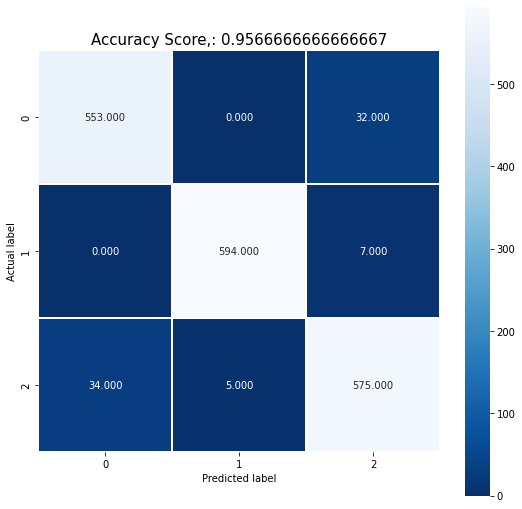

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score,: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(title,size=15)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       585
           1       0.99      0.99      0.99       601
           2       0.94      0.94      0.94       614

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800



In [ ]:
X_test1 = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)

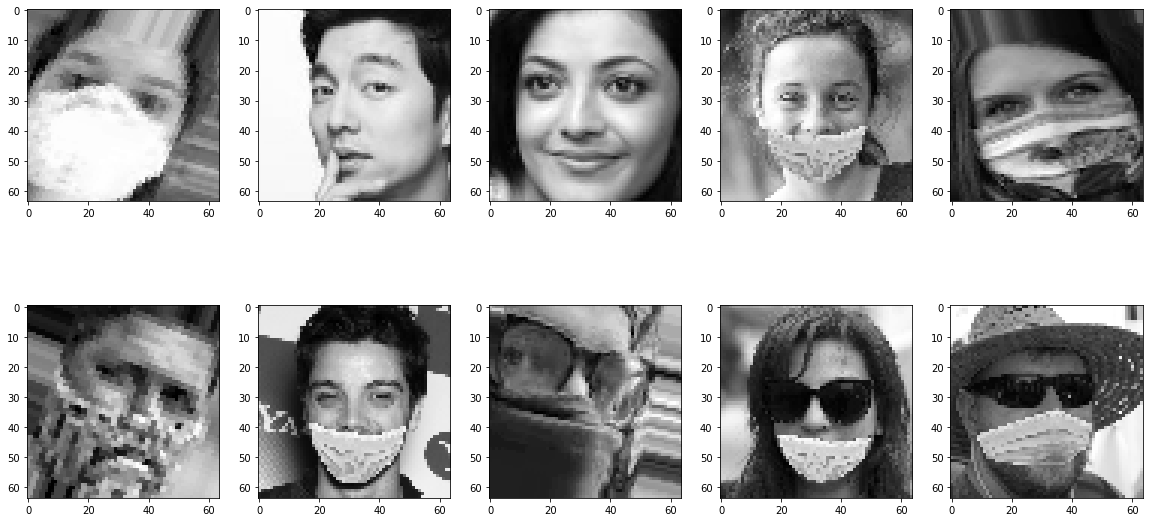

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i in np.arange(10):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X_test1[i],cmap=plt.cm.gray,interpolation='nearest')

In [ ]:
# RECALL
# CLASS 0: NO MASK
# CLASS 1: INCORRECT WEAR OF MASK
# CLASS 2: CORRECT WEAR OF MASK
#y_pred = model_100.predict(X_test)
pred=[]
test=[]
for r in range(60):
  pred.append(y_pred[r])
  test.append(y_test[r])
print(pred)
print(test)

[2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2]
[2, 0, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 1, 2, 2]


### SVM with PCA

In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(0.95) # Preserve 95% of the variance
X_train_transformed = pca.fit_transform(X_train) 
X_test_transformed = pca.transform(X_test) 
print(X_train_transformed.shape)
print(X_test_transformed.shape)
print(X_train.shape)

(7200, 440)
(1800, 440)
(7200, 4096)


In [ ]:
model_pca= svm.SVC()
model_pca.fit(X_train_transformed, y_train)


SVC()

In [ ]:
### 1. Get and print a baseline accuracy score.
y_pred_pca = model_pca.predict(X_test_transformed)
accuracy = model_pca.score(X_test_transformed, y_test)
print("Accuracy %f" % accuracy)
metrics.accuracy_score(y_test,y_pred_pca)

Accuracy 0.956111


0.9561111111111111

Text(0.5, 1.0, 'Accuracy Score, 0.9561111111111111')

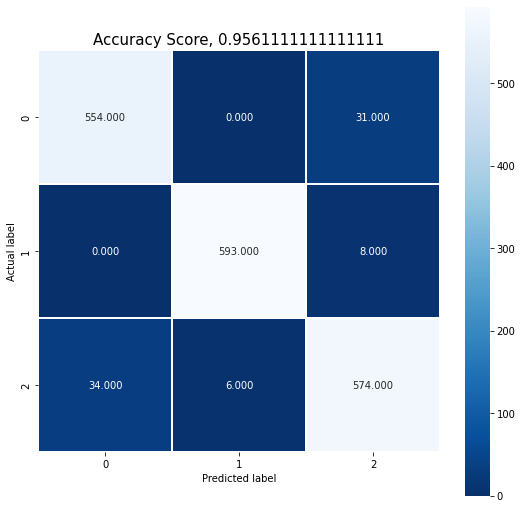

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score, {0}'.format(accuracy_score(y_test, y_pred_pca))
plt.title(title,size=15)

In [ ]:
print(metrics.classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       585
           1       0.99      0.99      0.99       601
           2       0.94      0.93      0.94       614

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800

